# Common settings

In [1]:
import datacube
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import math
import numpy as np
import pyproj
import rhealpixdggs.dggs as rhp
from rhealpixdggs.ellipsoids import Ellipsoid, WGS84_A, WGS84_F
from odc.ui import DcViewer
from datacube.utils import cog, masking

# Most functions defined by us are in this module to keep this notebook more clear
import rhealpix_workflow_functions as rwf

dc = datacube.Datacube(app="rhealpix pipeline validation")

# Uncomment to see available products and measurements:
#dc.list_products(dataset_count=True)
#dc.list_measurements()
#rwf.print_products_info(dc)

/root/miniconda3/envs/odc_env/lib/python3.8/site-packages/datacube/drivers/postgres/_connections.py:81: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  EngineUrl(


# Study area (the Pyrenees)
Selected by bounding box. We also define the min altitude that we will be considering (1500 meters).
For this notebook we just have one dataset (date 2022-04-26).


In [2]:
study_area_center = (42.6, 0.7) # lat/lon
study_area_width = 5.2
study_area_height = 1.6

study_area_lat = [study_area_center[0]-(study_area_height/2), study_area_center[0]+(study_area_height/2)]
study_area_lon = [study_area_center[1]-(study_area_width/2), study_area_center[1]+(study_area_width/2)]
study_area = [(study_area_lat[1],study_area_lon[0]), (study_area_lat[1],study_area_lon[1]),
              (study_area_lat[0],study_area_lon[1]), (study_area_lat[0],study_area_lon[0])] 


# Min altitude that we will be considering for the study
study_area_min_altitude = 1500

# Quick preview
m = folium.Map(location=study_area_center, zoom_start=6, tiles="Stamen Terrain")
folium.Rectangle(bounds=study_area, color='#ff0000', fill=True, fill_color='#ff0000', fill_opacity=0.1).add_to(m)
m

# Data selection & download
**Do I need anything here?**

# Pre-processing
- Setting common CRS and resolution.
- Load DEM and [Snow Cover Extension](https://land.copernicus.eu/global/products/sce) datasets from the Data cube.
- Load Aragón geometry as an array for use as a mask.

/root/miniconda3/envs/odc_env/lib/python3.8/site-packages/datacube/drivers/postgres/_api.py:535: SAWarning: Class CommonTimestamp will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  return self._connection.execute(select_query)
/root/miniconda3/envs/odc_env/lib/python3.8/site-packages/datacube/drivers/postgres/_api.py:535: SAWarning: Class Float8Range will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comp

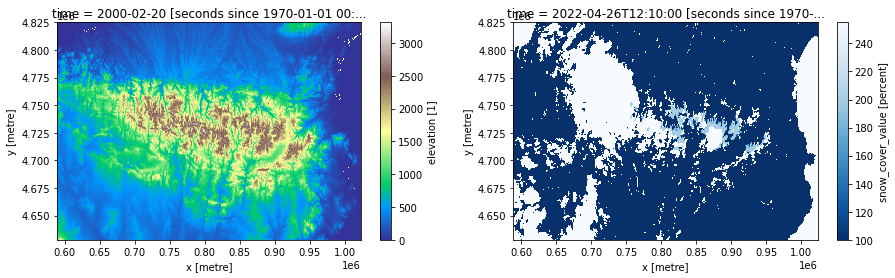

In [3]:
# Common CRS and resolution
# UTM 30N, ETRS89 ,is a common choice for this area
common_crs = "EPSG:25830"

# This is the resolution, in meters, of the c_gls_sce500 product
common_resolution = (-500, 500)

# Load datasets from Data Cube
nasadem_ds, sce500_ds = rwf.load_datasets(dc, study_area_lat, study_area_lon, common_crs, common_resolution)

# Load Aragón geometry mask (as an array)
polygon_mask_array = rwf.load_Aragón_geometry(dc, '/home/Aragón/Aragón_ETRS89_30N.shp', common_crs,
                                              out_shape = (len(sce500_ds["y"]), len(sce500_ds["x"])),
                                              transform = sce500_ds.geobox.transform)
# Quick preview of loaded datasets
_, axs = plt.subplots(1, 2, figsize=(15,4))
nasadem_ds.isel(time=0).elevation.where(nasadem_ds[dict(time=0)].elevation >= 0).plot(cmap="terrain", ax=axs[0])
sce500_ds.isel(time=0).snow_cover_value.plot(cmap="Blues_r", ax=axs[1])

# Processing
- DEM: mask nodata values, and generate a version for the whole area of study, and other one clipped with the Aragón geometry.
- SCE: mask nodata_values, mask other flags and generate a a version for the whole area of study, and other one clipped with the Aragón geometry.

/root/miniconda3/envs/odc_env/lib/python3.8/site-packages/datacube/utils/masking.py:123: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output_dtypes=[numpy.bool])
/root/miniconda3/envs/odc_env/lib/python3.8/site-packages/datacube/utils/masking.py:123: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output_dtypes=[numpy.bool])


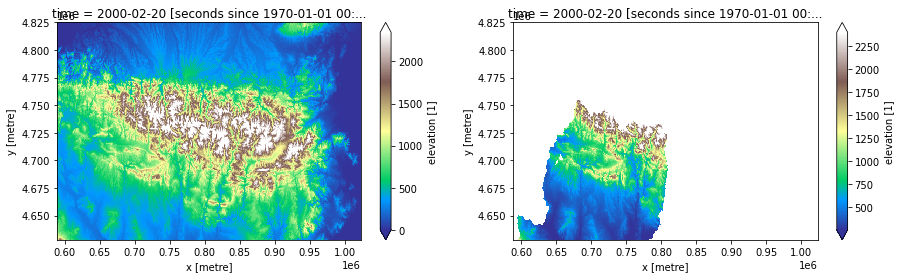

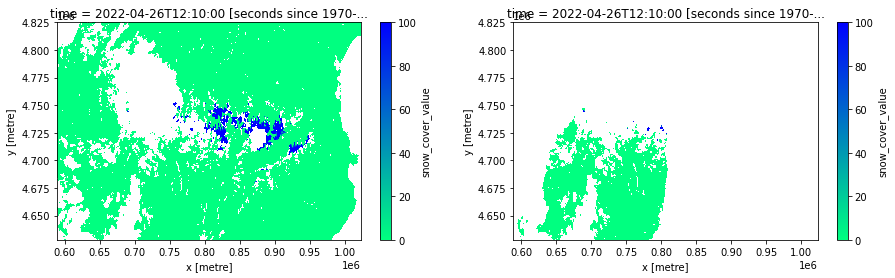

In [4]:
# DEM
nasadem_ds_WholeArea, nasadem_ds_Aragón = rwf.dem_processing(dc, nasadem_ds, polygon_mask_array)

# Quick preview
_, axs = plt.subplots(1, 2, figsize=(15,4))
nasadem_ds_WholeArea.isel(time=0).elevation.plot(cmap="terrain", ax=axs[0], robust=True) 
nasadem_ds_Aragón.isel(time=0).elevation.plot(cmap="terrain", ax=axs[1], robust=True) 

# SCE
sce500_ds_WholeArea, sce500_ds_Aragón = rwf.sce_processing(dc, sce500_ds, polygon_mask_array)

# Quick preview
# We use a  palette without whites so nodata areas are easily spotted
_, axs = plt.subplots(1, 2, figsize=(15,4))
sce500_ds_WholeArea.isel(time=0).snow_cover_value.plot(cmap="winter_r",ax=axs[0])
sce500_ds_Aragón.isel(time=0).snow_cover_value.plot(cmap="winter_r",ax=axs[1])

# Data integration and results presentation
Calculate and print the mean and stdev of the snow cover value in the Pyrenees (area of study, above the definead min altitude) and the same values for the Pyrenees that belong to the Aragón region. Plot the datasets.

Results
Snow cover values, Pyrenees, mean: 28.855747436589315
Snow cover values, Pyrenees, stdev: 43.81687189854463
Snow cover values, Aragón Pyrenees, mean: 10.879681274900399
Snow cover values, Aragón Pyrenees, stdev: 30.716942284751074


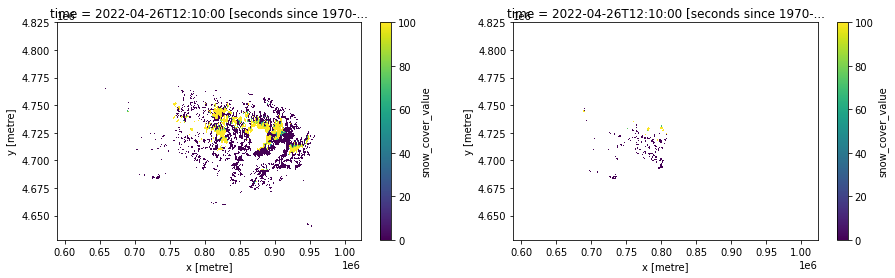

In [5]:
# Select cells from sce500 where height in the DEM is above the min height established for this study
sce500_Pyrenees, sce500_AragónPyrenees = rwf.get_result_datasets(sce500_ds_WholeArea, 
                                                                 sce500_ds_Aragón, 
                                                                 nasadem_ds_WholeArea,
                                                                 nasadem_ds_Aragón,
                                                                 study_area_min_altitude)

# Quick view
_, axs = plt.subplots(1, 2, figsize=(15,4))
sce500_Pyrenees.snow_cover_value.plot(ax=axs[0])
sce500_AragónPyrenees.snow_cover_value.plot(ax=axs[1])

print("Results")
print("=======")
print(f"Snow cover values, Pyrenees, mean: {sce500_Pyrenees.snow_cover_value.mean().values}")
print(f"Snow cover values, Pyrenees, stdev: {sce500_Pyrenees.snow_cover_value.std().values}")

print(f"Snow cover values, Aragón Pyrenees, mean: {sce500_AragónPyrenees.snow_cover_value.mean().values}")
print(f"Snow cover values, Aragón Pyrenees, stdev: {sce500_AragónPyrenees.snow_cover_value.std().values}")


Calculate and print the area with a snow cover value >= 75% in the Pyrenees (area of study, above the definead min altitude) and the same value for the Pyrenees that belong to the Aragón region. Plot the datasets.

Results
Snow cover values, Pyrenees; area with a snow cover >= 75%: 1269.75 km²
Snow cover values, Aragón Pyrenees; area with a snow cover >= 75%: 33.25 km²


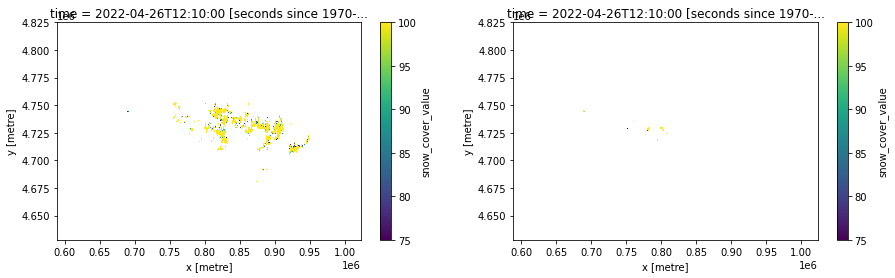

In [6]:
cell_area = common_resolution[0] ** 2
sce500_Pyrenees_75, sce500_AragónPyrenees_75 = rwf.get_area_result_datasets(sce500_Pyrenees, sce500_AragónPyrenees, 75)
    
sce500_Pyrenees_75_surface_km2 = sce500_Pyrenees_75.snow_cover_value.count().values * cell_area / 1e6
sce500_AragónPyrenees_75_surface_km2 = sce500_AragónPyrenees_75.snow_cover_value.count().values * cell_area / 1e6

# Quick view
_, axs = plt.subplots(1, 2, figsize=(15,4))
sce500_Pyrenees_75.snow_cover_value.plot(ax=axs[0])
sce500_AragónPyrenees_75.snow_cover_value.plot(ax=axs[1])

print("Results")
print("=======")
print(f"Snow cover values, Pyrenees; area with a snow cover >= 75%: {sce500_Pyrenees_75_surface_km2} km²")
print(f"Snow cover values, Aragón Pyrenees; area with a snow cover >= 75%: {sce500_AragónPyrenees_75_surface_km2} km²")

# Pre-processing with rHEALPix
- Setting a common rHEALPix DGGS, and choosing the common resolution.
- Load DEM, Snow Cover Extension and the Aragón limits datasets from the data cube whcih are already in the desired rHEALPix projection and resolution.

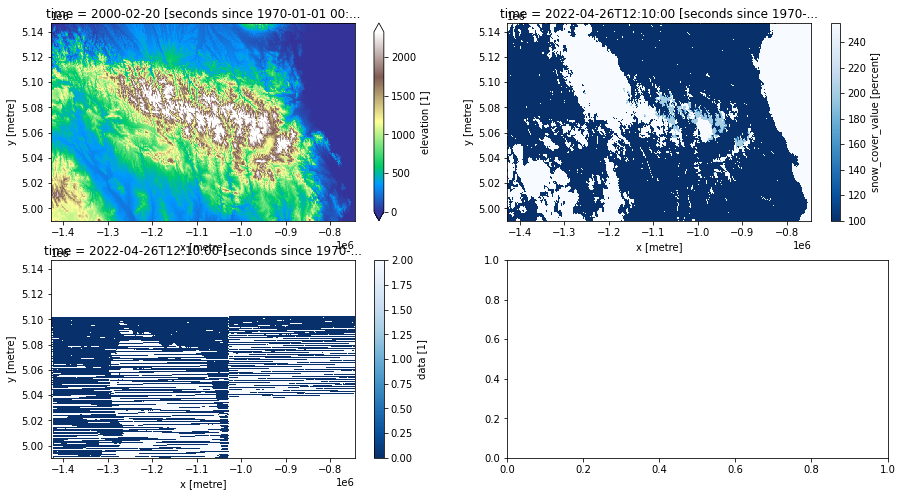

In [7]:
# Define the rHEALPix projection parameters
# South Square 0, North Square 1 (for example, not relevant for this study);
# prime meridian is 10th meridian east (so the area of study is 
# contained in a single "face of the cube"; simplifies some isses: at the very least this makes raster 
# datasets smaller, as the alternative includes far larger nodata areas). N_side is 3 (so each cell is refined
# into 9 at the next resolution level; for this study is not that relevant as we just
# use one resolution level).

south_square = 0
north_square = 1
lon_0 = 10
N_side = 3

rdggs = rhp.RHEALPixDGGS(ellipsoid=Ellipsoid(a=WGS84_A, f=WGS84_F, lon_0=10), north_square=north_square, 
                              south_square=south_square, N_side=N_side)
rhealpix_common_proj_string = f"+proj=rhealpix +south_square={south_square} +north_square={north_square} "\
                              f"+lon_0={lon_0}"
rhealpix_common_crs = pyproj.CRS(rhealpix_common_proj_string).to_wkt()

# We will be using this as the resolution index. For the given rhealpix parameters, it is the resolution
# level for cells with 508.72 meters of size, which is the closest one to the resolution of the sce_500 data 
# we are using (500 meters)
rhealpix_common_resolution_index = 9

# Load data from the data cube

# Width of the cells for rhealpix with N_side 3 at resolution level (planar, in meters)
rhealpix_common_resolution = rdggs.cell_width(rhealpix_common_resolution_index)

# This fixes (or provides a workaround) for an issue: when loading the rhealpix data from the datacube,
# they are displaced half a pixel in vertical (but not in horizontal). I assume it is some kind of 
# ""pixel is area" vs "pixel is point" issue, maybe ith the datasets themselves, maybe with the 
# product/dataset metadata, or in the dc.load method or wherever. Using this forced_align for the
# align parameter in the dc.load methods solves this issue.
forced_align=(rhealpix_common_resolution / 2, 0)

nasadem_rhealpix_ds, sce500_rhealpix_ds, Aragón_rhealpix_mask_ds = rwf.load_datasets_rhealpix(dc, study_area_lat, study_area_lon, forced_align)

# Quick preview
_, axs = plt.subplots(2, 2, figsize=(15,8))
nasadem_rhealpix_ds.isel(time=0).elevation.plot(cmap="terrain", ax=axs[0][0], robust=True) 
sce500_rhealpix_ds.isel(time=0).snow_cover_value.plot(cmap="Blues_r", ax=axs[0][1], robust=True)
# In this dataset,a value of 2 is "Aragón" and 0 is "not Aragón". As 255 is nodata and
# we have not masked it yet, we plot smaller valures only.
Aragón_rhealpix_mask_ds.isel(time=0).data.where(Aragón_rhealpix_mask_ds.data < 255).plot(cmap="Blues_r", ax=axs[1][0])

## Processing with rHEALPix

- DEM: mask nodata values, and generate a version for the whole area of study, and other one clipped with the Aragón geometry (which is now already a rHEALPix dataset in the data cube).
- SCE: mask nodata_values, mask other flags and generate a a version for the whole area of study, and other one clipped with the Aragón geometry.

/root/miniconda3/envs/odc_env/lib/python3.8/site-packages/datacube/utils/masking.py:123: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output_dtypes=[numpy.bool])
/root/miniconda3/envs/odc_env/lib/python3.8/site-packages/datacube/utils/masking.py:123: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output_dtypes=[numpy.bool])


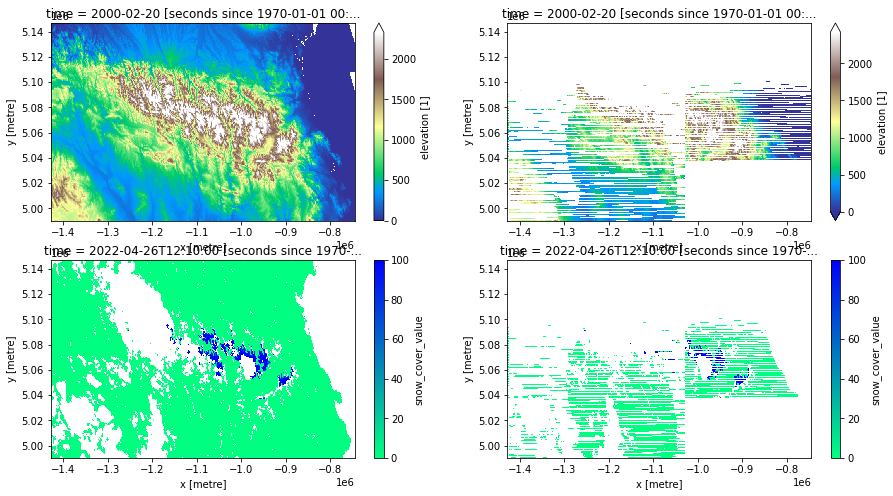

In [8]:
nasadem_rhealpix_ds_WholeArea, nasadem_rhealpix_ds_Aragón = rwf.dem_rhealpix_processing(dc, 
                                                                nasadem_rhealpix_ds,
                                                                Aragón_rhealpix_mask_ds[dict(time=0)])

sce500_rhealpix_ds_WholeArea, sce500_rhealpix_ds_Aragón = rwf.sce_rhealpix_processing(dc, 
                                                              sce500_rhealpix_ds,
                                                              Aragón_rhealpix_mask_ds[dict(time=0)])

# Quick preview
_, axs = plt.subplots(2, 2, figsize=(15,8))
nasadem_rhealpix_ds_WholeArea.isel(time=0).elevation.where(nasadem_rhealpix_ds_WholeArea[dict(time=0)].elevation >= 0).plot(cmap="terrain", ax=axs[0][0], robust=True)
nasadem_rhealpix_ds_Aragón.isel(time=0).elevation.plot(cmap="terrain", ax=axs[0][1], robust=True)

# For this we use a palette without whites so nodata areas are easily spotted
sce500_rhealpix_ds_WholeArea.isel(time=0).snow_cover_value.plot(cmap="winter_r",ax=axs[1][0])
sce500_rhealpix_ds_Aragón.isel(time=0).snow_cover_value.plot(cmap="winter_r",ax=axs[1][1])


# Data integration and results presentation with rHEALPix
The same as above, but calculated starting from the rHEALPix datasets: calculate and print the mean and stdev of the snow cover value in the Pyrenees (area of study, above the definead min altitude) and the same values for the Pyrenees that belong to the Aragón region. Plot the datasets.

rHEALPix Snow cover values, Pyrenees, mean: 28.26641871851608
rHEALPix Snow cover values, Pyrenees, stdev: 43.55038032230698
rHEALPix Snow cover values, Aragón Pyrenees, mean: 26.14258039519566
rHEALPix Snow cover values, Aragón Pyrenees, stdev: 42.26732785386139


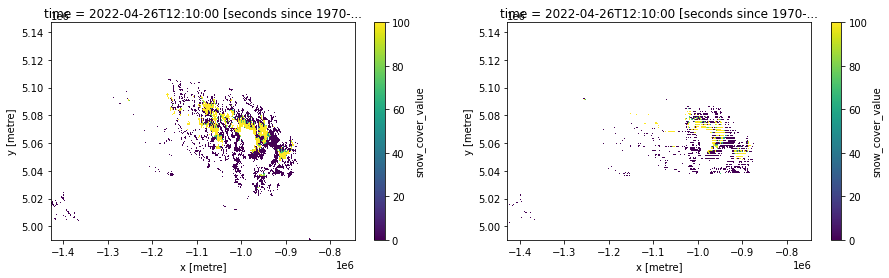

In [9]:
# Select cells from sce500 (rHEALPix) where height in the DEM is above the min height established for this study
sce500_rhealpix_Pyrenees = \
    sce500_rhealpix_ds_WholeArea.where(nasadem_rhealpix_ds_WholeArea[dict(time=0)].elevation >= study_area_min_altitude)
sce500_rhealpix_AragónPyrenees = \
    sce500_rhealpix_ds_Aragón.where(nasadem_rhealpix_ds_WholeArea[dict(time=0)].elevation >= study_area_min_altitude)

_, axs = plt.subplots(1, 2, figsize=(15,4))
sce500_rhealpix_Pyrenees.snow_cover_value.plot(ax=axs[0])
sce500_rhealpix_AragónPyrenees.snow_cover_value.plot(ax=axs[1])

print(f"rHEALPix Snow cover values, Pyrenees, mean: {sce500_rhealpix_Pyrenees.snow_cover_value.mean().values}")
print(f"rHEALPix Snow cover values, Pyrenees, stdev: {sce500_rhealpix_Pyrenees.snow_cover_value.std().values}")

print(f"rHEALPix Snow cover values, Aragón Pyrenees, mean: {sce500_rhealpix_AragónPyrenees.snow_cover_value.mean().values}")
print(f"rHEALPix Snow cover values, Aragón Pyrenees, stdev: {sce500_rhealpix_AragónPyrenees.snow_cover_value.std().values}")

The same as above, but calculated starting from the rHEALPix datasets: calculate and print the area with a snow cover value >= 75% in the Pyrenees (area of study, above the definead min altitude) and the same value for the Pyrenees that belong to the Aragón region. Plot the datasets.

Results
rHEALPix Snow cover values, Pyrenees; area with a snow cover >= 75%: 1253.9012769950323 km²
rHEALPix Snow cover values, Aragón Pyrenees; area with a snow cover >= 75%: 416.2829221978953 km²


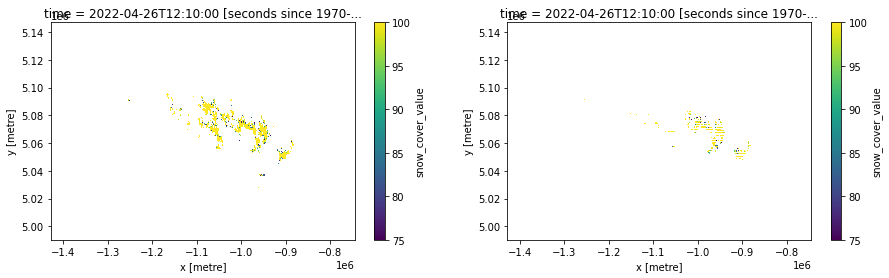

In [10]:
# rHEALPix is equiareal but not area-preserving. To calculate the actual area of a cell we must divide 
# its projected area by (3*PI/8)
cell_area = rhealpix_common_resolution ** 2 / (3 * np.pi / 8)
sce500_rhealpix_Pyrenees_75, sce500_rhealpix_AragónPyrenees_75 = \
    rwf.get_area_result_datasets(sce500_rhealpix_Pyrenees, sce500_rhealpix_AragónPyrenees, 75)

sce500_rhealpix_Pyrenees_75_surface_km2 = sce500_rhealpix_Pyrenees_75.snow_cover_value.count().values * cell_area / 1e6
sce500_rhealpix_AragónPyrenees_75_surface_km2 = sce500_rhealpix_AragónPyrenees_75.snow_cover_value.count().values * cell_area / 1e6

    
# Quick view
_, axs = plt.subplots(1, 2, figsize=(15,4))
sce500_rhealpix_Pyrenees_75.snow_cover_value.plot(ax=axs[0])
sce500_rhealpix_AragónPyrenees_75.snow_cover_value.plot(ax=axs[1])

print("Results")
print("=======")
print(f"rHEALPix Snow cover values, Pyrenees; area with a snow cover >= 75%: {sce500_rhealpix_Pyrenees_75_surface_km2} km²")
print(f"rHEALPix Snow cover values, Aragón Pyrenees; area with a snow cover >= 75%: {sce500_rhealpix_AragónPyrenees_75_surface_km2} km²")

Another difference between the datasets produced using the Common CRS and those with rHEALPix is that in the rHEALPix raster dataset, because we have created it carefully, each pixel corresponds exactly to one cell in the rHEALPix DGGS at a certain resolution level. Each pixel in the dataset thus has exactly one valid cell identifier from among the set of valid cell identifiers of the DGGS.

To show this point, we create now a GeoDataFrame with the cell identifer for each pixel which has a snow cover which is not NaN. In order to make it easier to visualize it, we are also adding the centroid of those cells to the GeoDataFrame (so we are creating a point dataset). Storing the centroids is totally optional: each cell identifer in a rHEALPix DGGS corresponds exactly to one centroid that can be easily produced by the rHEALPix library at any time from the cell identifier if we need it.

       cellid                          geometry  snow_cover
0  N878818335  POINT (-1166244.489 5095865.234)       100.0
1  N878818343  POINT (-1165735.768 5095865.234)       100.0
2  N878818344  POINT (-1165227.046 5095865.234)       100.0
3  N878817556  POINT (-1168788.098 5095356.513)       100.0
4  N878817557  POINT (-1168279.376 5095356.513)       100.0
...
          cellid                         geometry  snow_cover
5703  N886762852  POINT (-948002.882 5036853.518)        80.0
5704  N886764526  POINT (-962755.811 5028205.249)        85.0
5705  N886764527  POINT (-962247.089 5028205.249)        85.0
5706  N886764528  POINT (-961738.367 5028205.249)       100.0
5707  N886765306  POINT (-961229.646 5028205.249)        99.0


<AxesSubplot:>

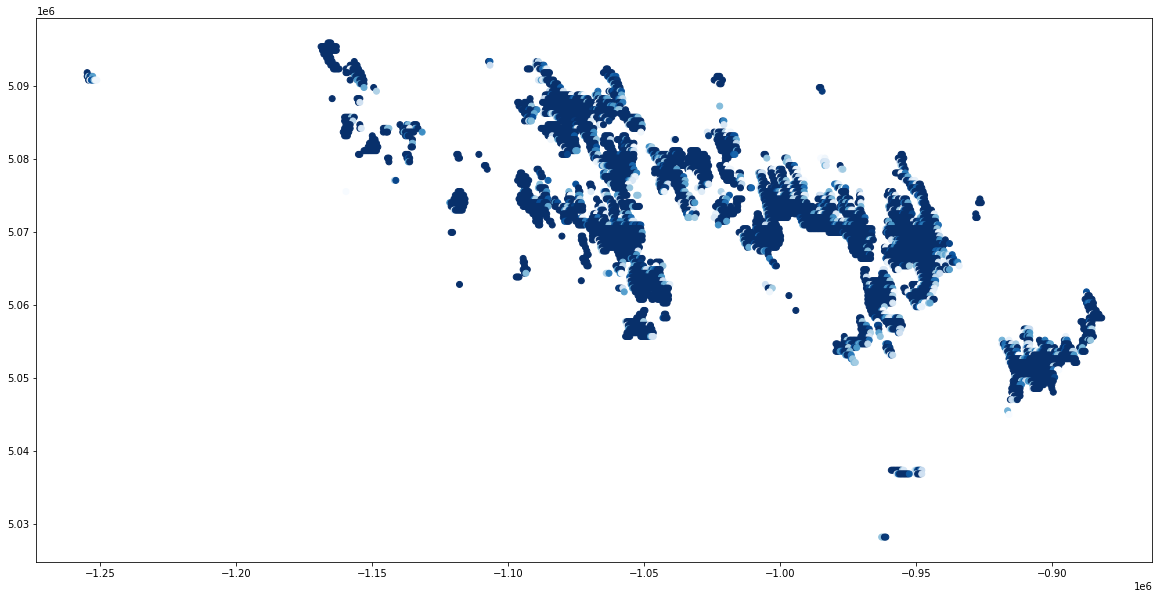

In [11]:
# Create a GeoDataFrame for the Pyrenees dataset that only has those pixels which snow cover is >=75%
gdf = rwf.rhealpix_ds_to_geodataframe(sce500_rhealpix_Pyrenees_75, rdggs, rhealpix_common_proj_string, rhealpix_common_resolution_index)

# Quick view
# It is a point dataset with the centroids of each rHEALPix cell, plus its cell identifiers and snow_covers
print(gdf.head())
print("...")
print(gdf.tail())
gdf.plot("snow_cover", cmap="Blues", figsize=(20,10), aspect=None)

# Unconmment the next lines to write the vector (DGGS) and raster files, as a GeoPackage and TIFF files
# Write as Geopackage
# gdf.to_file('Pyrenees_rhealpix_75.gpkg', driver='GPKG', layer='snow_cover_above_75')

# Write GeoTIFF to a location
# import datacube.utils.cog as duc
# duc.write_cog(geo_im=sce500_rhealpix_Pyrenees_75.snow_cover_value,fname='Pyrenees_rhealpix_75.tif', overwrite=True)

# Validation of the results by comparing the results of both strategies

In [12]:
print("Pyrenees snow cover value")      
print(f"Using rHEALPix: Mean = {sce500_rhealpix_Pyrenees.snow_cover_value.mean().values}, stdev = {sce500_rhealpix_Pyrenees.snow_cover_value.std().values}")        
print(f"Using the Common CRS: Mean = {sce500_Pyrenees.snow_cover_value.mean().values}, stdev = {sce500_Pyrenees.snow_cover_value.std().values}")        
print(f"Normalized difference between those means (Cohen's d): {rwf.calc_cohen_d(sce500_rhealpix_Pyrenees.snow_cover_value.values.flatten(), sce500_Pyrenees.snow_cover_value.values.flatten())}")    
print("----------------------------------")
print("Pyrenees area with >= 75% of snow cover")
diff = abs(sce500_rhealpix_Pyrenees_75_surface_km2 - sce500_Pyrenees_75_surface_km2)
print(f"Absolute difference between the area calculated with rHEALPix and with the Common CRS: {diff} km²")
print(f"This difference is a {100 * (diff/sce500_Pyrenees_75_surface_km2)} % of the area calculated with the Common CRS.")

print("==================================")

print("Aragón Pyrenees snow cover value")
print(f"Using rHEALPix: Mean = {sce500_rhealpix_AragónPyrenees.snow_cover_value.mean().values}, stdev = {sce500_rhealpix_AragónPyrenees.snow_cover_value.std().values}")        
print(f"Using the Common CRS: Mean = {sce500_AragónPyrenees.snow_cover_value.mean().values}, stdev = {sce500_AragónPyrenees.snow_cover_value.std().values}")        
print(f"Normalized difference between those means (Cohen's d): {rwf.calc_cohen_d(sce500_rhealpix_AragónPyrenees.snow_cover_value.values.flatten(), sce500_AragónPyrenees.snow_cover_value.values.flatten())}")    
print("----------------------------------")
print("Aragón Pyrenees area with >= 75% of snow cover")
diff = abs(sce500_rhealpix_AragónPyrenees_75_surface_km2 - sce500_AragónPyrenees_75_surface_km2)
print(f"Absolute difference between the area calculated with rHEALPix and with the Common CRS: {diff} km²")
print(f"This difference is a {100 * (diff/sce500_AragónPyrenees_75_surface_km2)} % of the area calculated with the Common CRS.")



Pyrenees snow cover value
Using rHEALPix: Mean = 28.26641871851608, stdev = 43.55038032230698
Using the Common CRS: Mean = 28.855747436589315, stdev = 43.81687189854463
Normalized difference between those means (Cohen's d): -0.01349467048679622
----------------------------------
Pyrenees area with >= 75% of snow cover
Absolute difference between the area calculated with rHEALPix and with the Common CRS: 15.848723004967724 km²
This difference is a 1.2481766493378794 % of the area calculated with the Common CRS.
Aragón Pyrenees snow cover value
Using rHEALPix: Mean = 26.14258039519566, stdev = 42.26732785386139
Using the Common CRS: Mean = 10.879681274900399, stdev = 30.716942284751074
Normalized difference between those means (Cohen's d): 0.4072044440435079
----------------------------------
Aragón Pyrenees area with >= 75% of snow cover
Absolute difference between the area calculated with rHEALPix and with the Common CRS: 383.0329221978953 km²
This difference is a 1151.9787133771285 % 

In the next cell, we compare the resulting datasets spatially. We reproject the Pyrenees snow cover in rHEALPix to the common CRS (UTM 30N, ETRS89) and compare that to the result obtained when working directly with the common CRS.  

To compare visually, we plot both versions plus the difference between them. For a quantitative comparison, we calculate the MAE, BIAS and Spearman's R. 

We do the same for the Aragón Pyrenees.

Pyrenees; rHEALPIX reprojected to common CRS against the common CRS version in the datacube: 
MAE= 2.659514220991694; BIAS = -0.39636294991190535; Spearman's rho = 0.9525056849445376.
Aragón Pyrenees; rHEALPIX reprojected to common CRS against the common CRS version in the datacube: 
MAE = 0.0; BIAS = 0.0; Spearman's rho = 1.0.


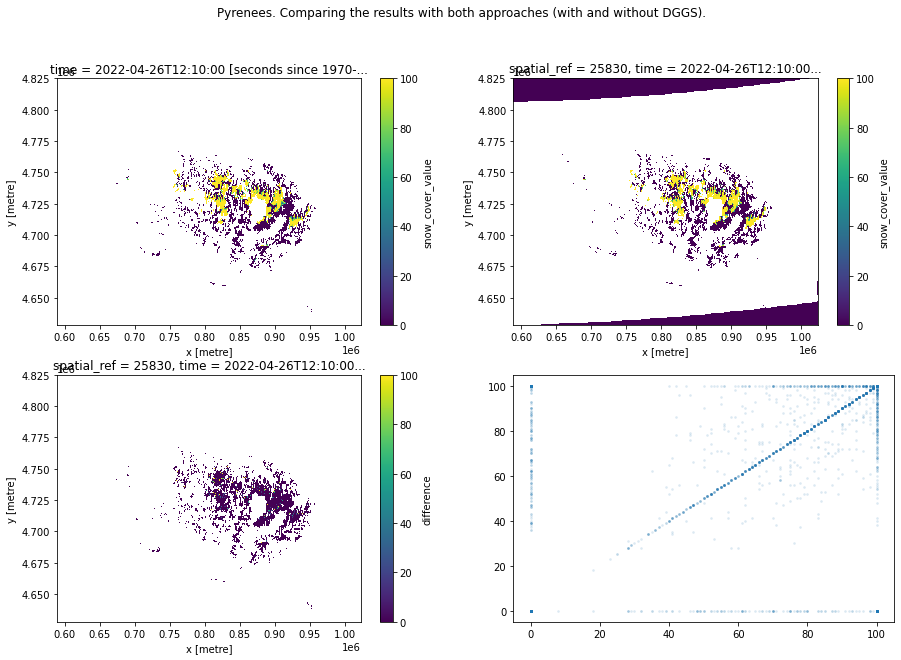

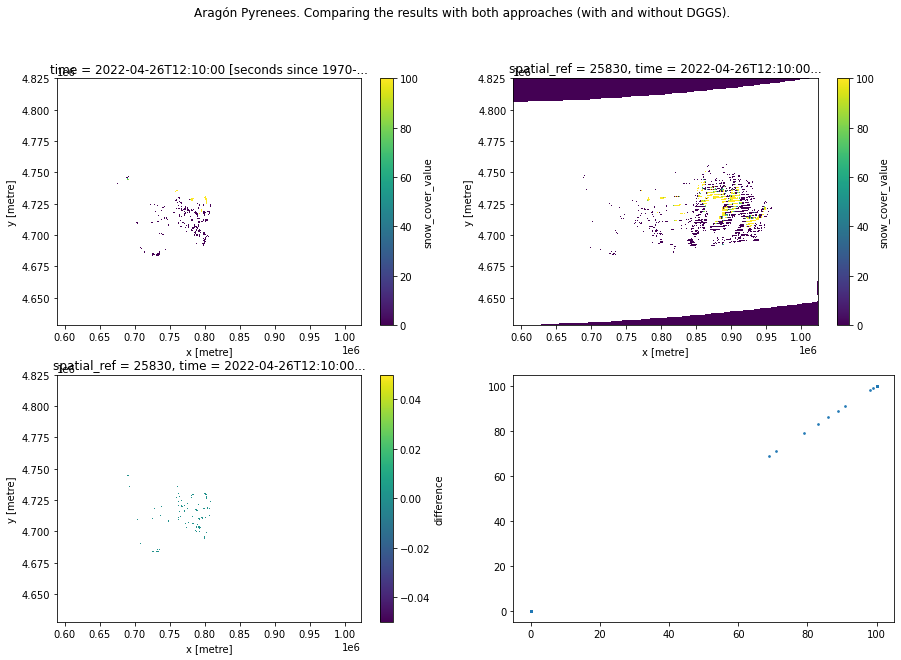

In [13]:
from odc.algo import xr_reproject

# Pyrenees
sce500_Pyrenees_rhealpix_to_common = xr_reproject(src=sce500_rhealpix_Pyrenees,
                                                  geobox=sce500_Pyrenees.geobox,
                                                  resampling="nearest")


mae, bias, r = rwf.calc_mae_bias_r(
    sce500_Pyrenees_rhealpix_to_common.snow_cover_value,
    sce500_Pyrenees.snow_cover_value)
print(f"Pyrenees; rHEALPIX reprojected to common CRS against the common CRS version in the datacube: ")
print(f"MAE= {mae}; BIAS = {bias}; Spearman's rho = {r}.")

# To plot the absolute difference
differencePyrenees = abs(sce500_Pyrenees_rhealpix_to_common - sce500_Pyrenees)
differencePyrenees = differencePyrenees.rename_vars({"snow_cover_value": "difference"})

fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle("Pyrenees. Comparing the results with both approaches (with and without DGGS).")
sce500_Pyrenees.snow_cover_value.plot(ax=axs[0][0])
sce500_Pyrenees_rhealpix_to_common.snow_cover_value.plot(ax=axs[0][1])
differencePyrenees.difference.plot(ax=axs[1][0])
plt.scatter(sce500_Pyrenees_rhealpix_to_common.snow_cover_value.values.flatten(), 
            sce500_Pyrenees.snow_cover_value.values.flatten(), s=3, alpha=0.1)




# Aragón Pyrenees
sce500_AragónPyrenees_rhealpix_to_common = xr_reproject(src=sce500_rhealpix_AragónPyrenees,
                                                        geobox=sce500_AragónPyrenees.geobox,
                                                        resampling="nearest")

mae, bias, r = rwf.calc_mae_bias_r(sce500_AragónPyrenees_rhealpix_to_common.snow_cover_value,
                            sce500_AragónPyrenees.snow_cover_value)
print(f"Aragón Pyrenees; rHEALPIX reprojected to common CRS against the common CRS version in the datacube: ")
print(f"MAE = {mae}; BIAS = {bias}; Spearman's rho = {r}.")


differenceAragónPyrenees = abs(sce500_AragónPyrenees_rhealpix_to_common - sce500_AragónPyrenees)
differenceAragónPyrenees = differenceAragónPyrenees.rename_vars({"snow_cover_value": "difference"})

fig, axs = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle("Aragón Pyrenees. Comparing the results with both approaches (with and without DGGS).")
sce500_AragónPyrenees.snow_cover_value.plot(ax=axs[0][0])
sce500_AragónPyrenees_rhealpix_to_common.snow_cover_value.plot(ax=axs[0][1])
differenceAragónPyrenees.difference.plot(ax=axs[1][0])
plt.scatter(sce500_AragónPyrenees_rhealpix_to_common.snow_cover_value.values.flatten(), 
            sce500_AragónPyrenees.snow_cover_value.values.flatten(), s=3, alpha=0.9)


# Prettier maps for the manuscript

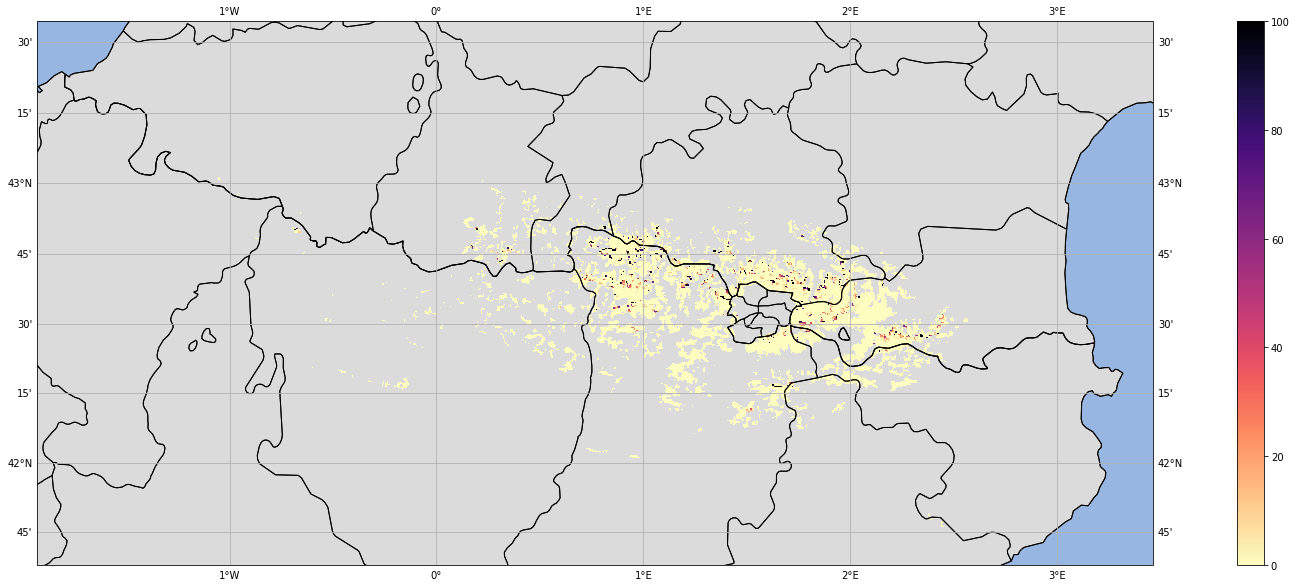

In [16]:
import cartopy.crs as ccrs
import cartopy.feature as cf

fig = plt.figure()
# fig.suptitle("Pyrenees: absolute difference between the UTM dataset and the rHEALPix dataset projected to UTM")
fig.set_figheight(10)
fig.set_figwidth(30)

crs = ccrs.epsg(common_crs[5:]) # Common CRS expressed as Cartopy CRS

# We will be using Mercator to show our results
ax1 = fig.add_subplot(111, projection=ccrs.Mercator())
ax1.add_feature(cf.COASTLINE)
ax1.add_feature(cf.BORDERS)
ax1.add_feature(cf.STATES)
ax1.add_feature(cf.OCEAN)
ax1.add_feature(cf.LAND, facecolor=cf.COLORS["land_alt1"]) 
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

differencePyrenees.difference.plot(ax=ax1, cmap="magma_r", add_labels=False, transform=crs)

plt.show()
# Comment the plt.show() and uncomment the next line to save as a png image. 
# plt.savefig('diffs_Pyrenees.png', bbox_inches='tight')
# Uncomment this for a vector representation in PDF (e.g., for printing)
# plt.savefig('diffs_Pyrenees.ppdf', bbox_inches='tight')

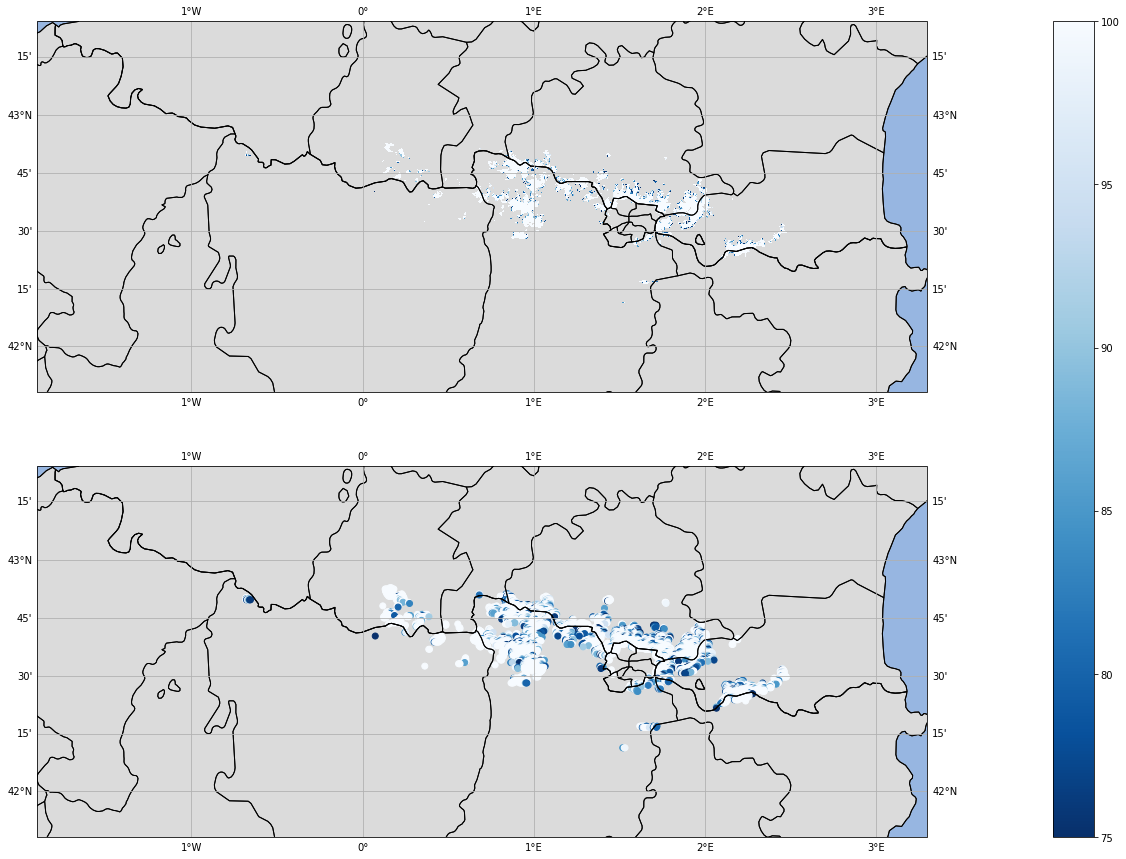

In [15]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(45)

crs = ccrs.epsg(common_crs[5:]) # Common CRS expressed as Cartopy CRS

# Cartopy does not support rHEALPix, so we transform to Common CRS...
sce500_rhealpix_Pyrenees_75_common = xr_reproject(src=sce500_rhealpix_Pyrenees_75,
                                                  geobox=sce500_Pyrenees_75.geobox,
                                                  resampling="nearest")
# ... and remove values 0 so we don't see "wedges" with no actual values
sce500_rhealpix_Pyrenees_75_common = \
    sce500_rhealpix_Pyrenees_75_common.where(sce500_rhealpix_Pyrenees_75_common.snow_cover_value > 0)


ax1 = fig.add_subplot(211, projection=ccrs.Mercator())
ax1.add_feature(cf.COASTLINE)
ax1.add_feature(cf.BORDERS)
ax1.add_feature(cf.STATES)
ax1.add_feature(cf.OCEAN)
ax1.add_feature(cf.LAND, facecolor=cf.COLORS["land_alt1"])
ax1.set_extent([study_area_lon[0], study_area_lon[1], study_area_lat[0], study_area_lat[1]])
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax2 = fig.add_subplot(212, projection=ccrs.Mercator())
ax2.add_feature(cf.COASTLINE)
ax2.add_feature(cf.BORDERS)
ax2.add_feature(cf.STATES)
ax2.add_feature(cf.OCEAN)
ax2.add_feature(cf.LAND, facecolor=cf.COLORS["land_alt1"])
ax2.set_extent([study_area_lon[0], study_area_lon[1], study_area_lat[0], study_area_lat[1]])
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

im = sce500_rhealpix_Pyrenees_75_common.snow_cover_value.plot(ax=ax1, transform=crs, cmap="Blues_r", add_labels=False, add_colorbar=False)

gdf = rwf.rhealpix_ds_to_geodataframe(sce500_rhealpix_Pyrenees_75, rdggs, rhealpix_common_proj_string, rhealpix_common_resolution_index)
# Again, to Common CRS because Cartopy does not support rHEALPix
gdf_common = gdf.to_crs(common_crs)
gdf_common.plot(ax=ax2, column="snow_cover", cmap="Blues_r", transform=crs)

# Draw a single colorbar
import matplotlib
cax,kw = matplotlib.colorbar.make_axes([ax for ax in [ax1, ax2]])
plt.colorbar(im, cax=cax, **kw)

plt.show()
# Comment the plt.show() and uncomment the next line to save as a png image. 
# plt.savefig('snow_cover_75_rhealpix.png', bbox_inches='tight')
# Uncomment this for a vector representation in PDF (e.g., for printing)
# plt.savefig('snow_cover_75_rhealpix.pdf', bbox_inches='tight')

To show that both versions of the dataset (raster and vector) in rhealpix have a one to one correspondence (pixel <-> cell) we can save them as files (GeoTIFF and GeoPackage), open them with a desktop GIS tool, overlay them and see the result. Using cartopy does not work well here, because it does not support rHEALPix; and reprojecting to another CRS, it includes resampling the raster, to show them together distorts the true results too much.